In [11]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

In [12]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [13]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [14]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
   # "total_precipitation_2023"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
  #  "total_precipitation_2023": "Precip"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# CatBoost

In [15]:
# CatBoost parameters
cat_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'verbose': False,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 20,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bernoulli'
}

### CatBoost - Within Domain

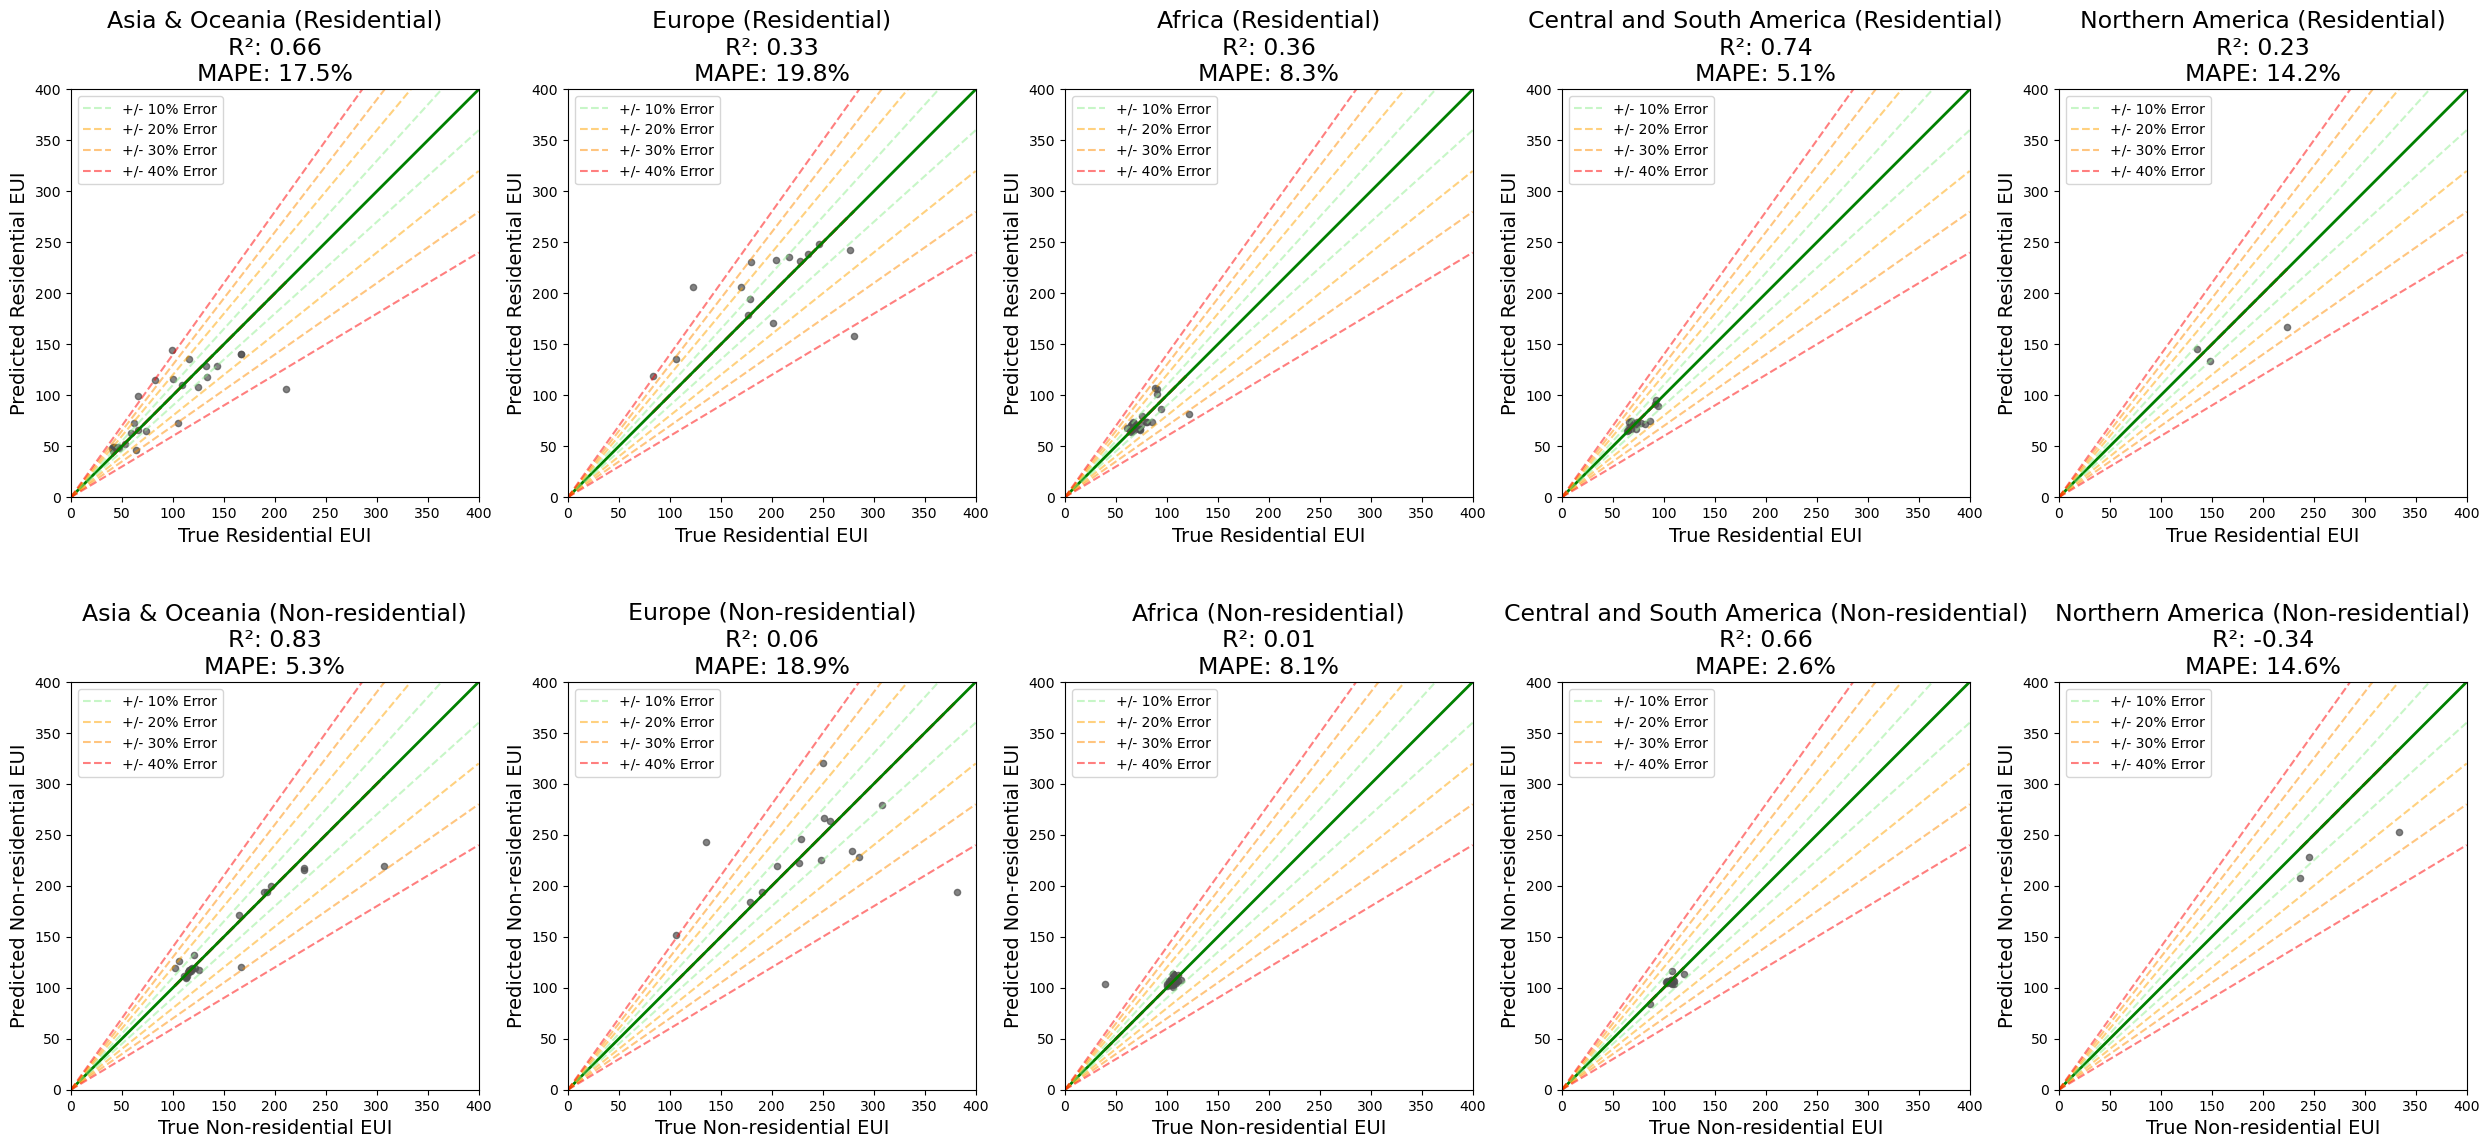

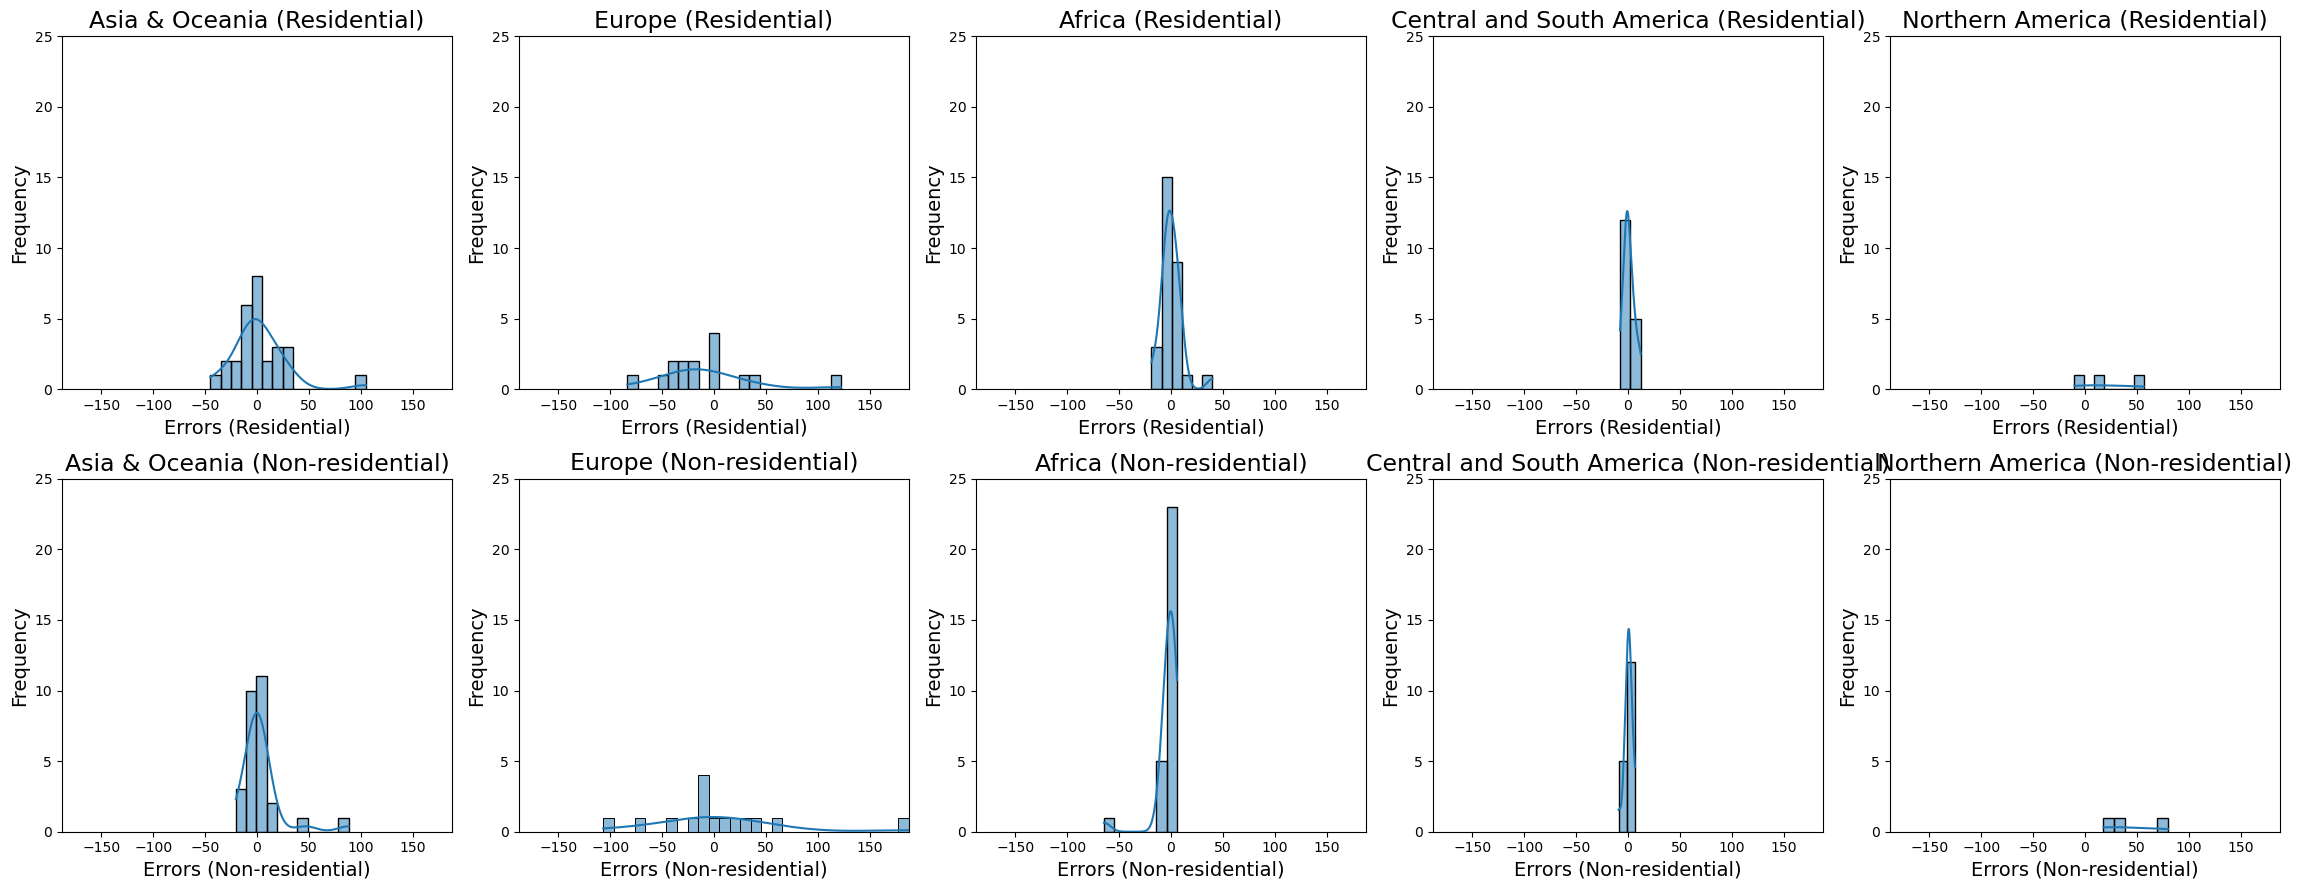

In [16]:
# Within Domain
model_cat_within = CatBoostRegressor(**cat_params)
results_cat_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_cat_within, 
    save_path='../figures/model_plots/cat_within_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_within,
    save_path='../figures/model_plots/cat_within_domain_error_distribution.png')

### CatBoost - Cross Domain

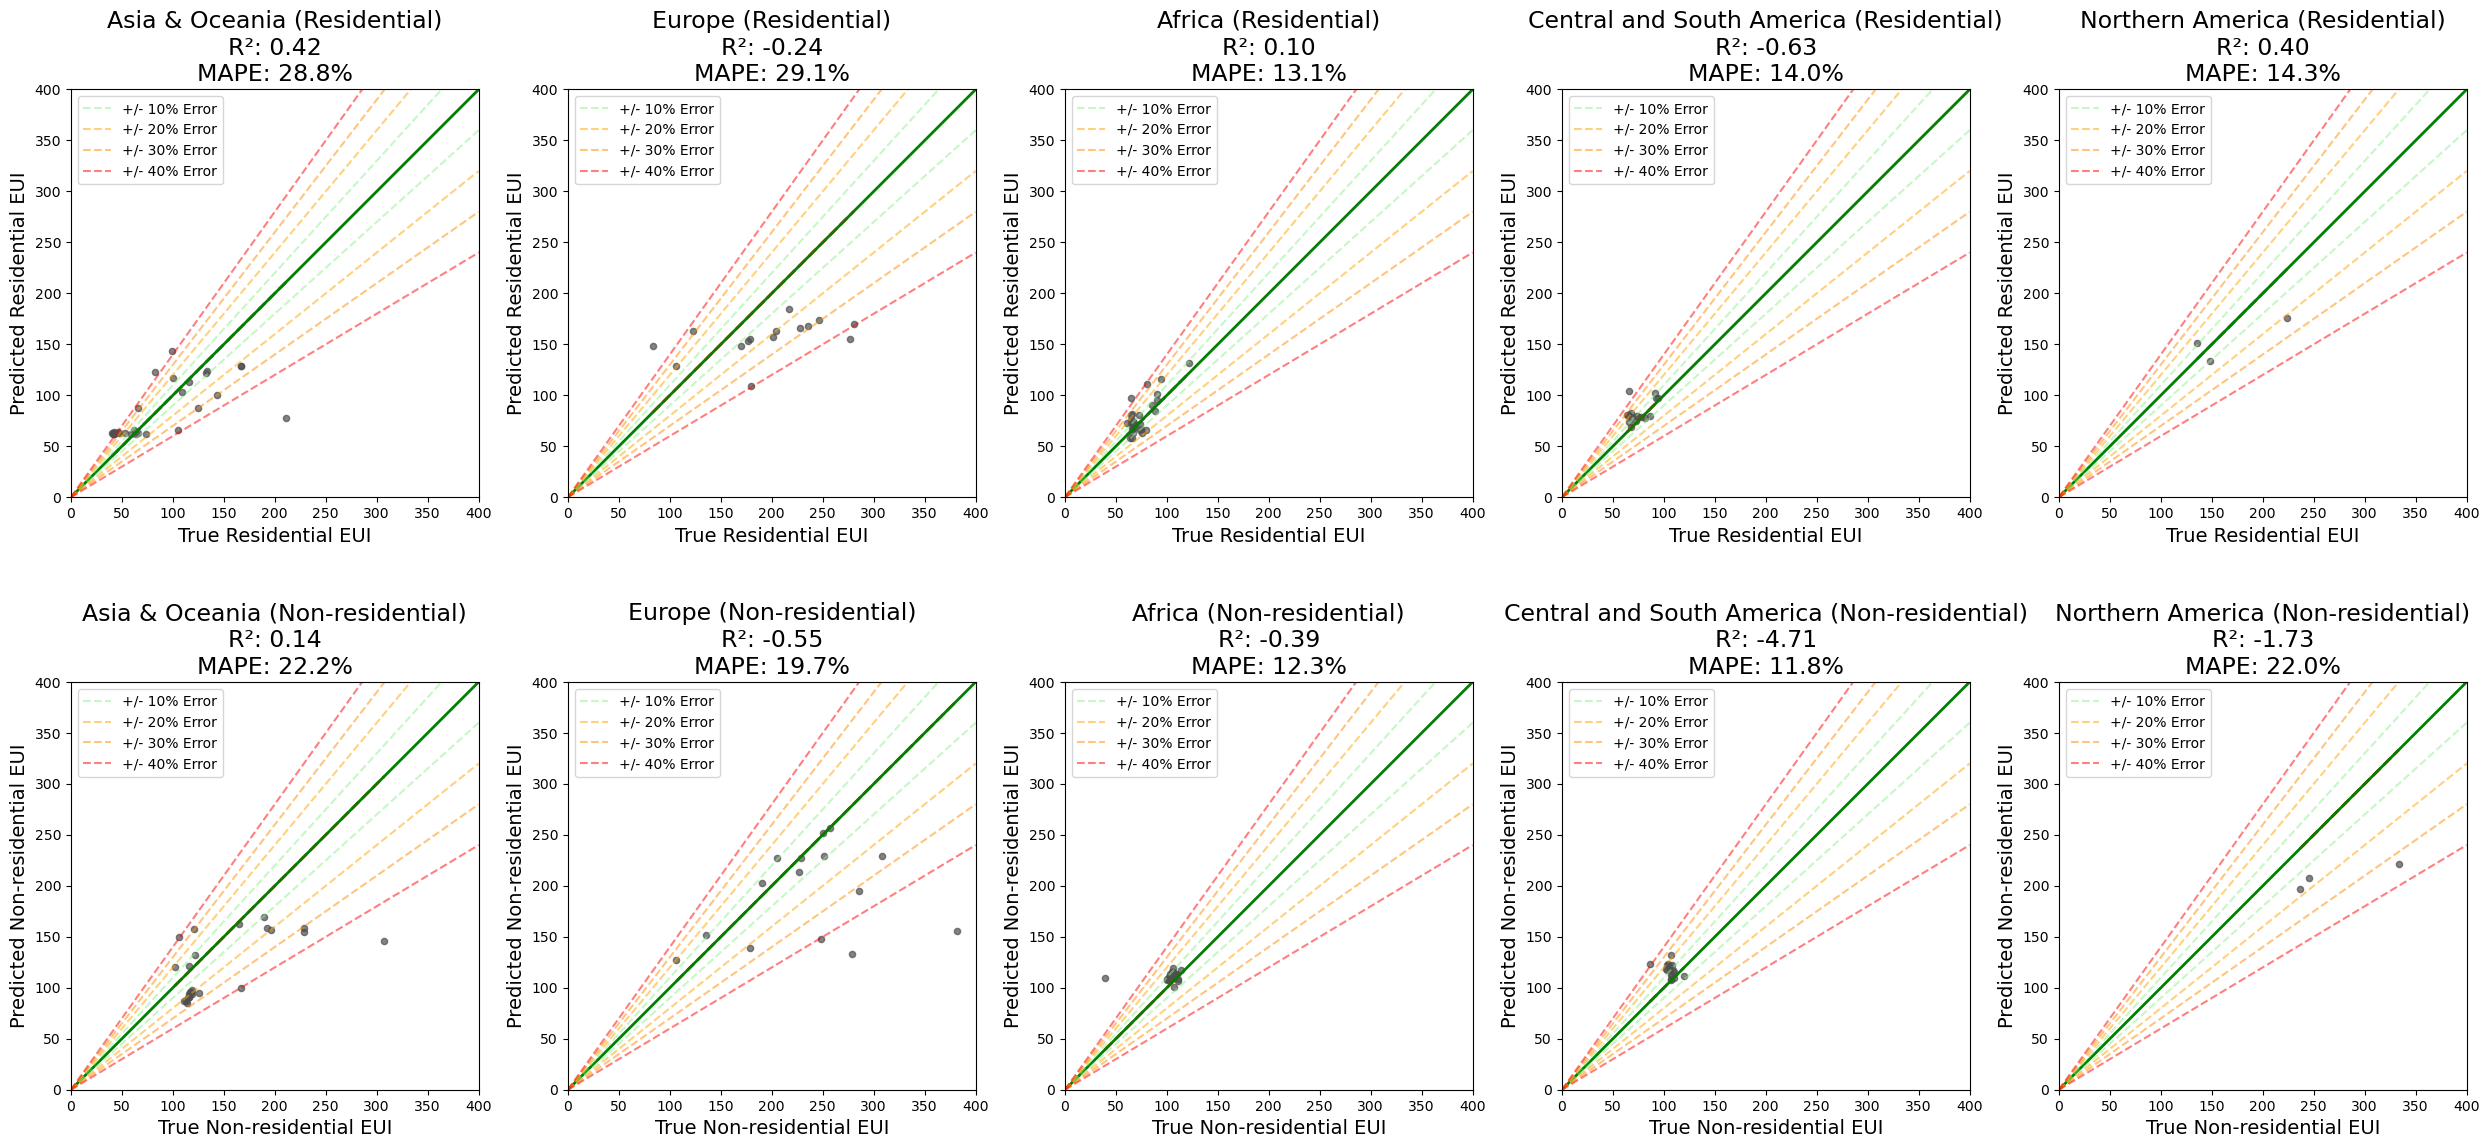

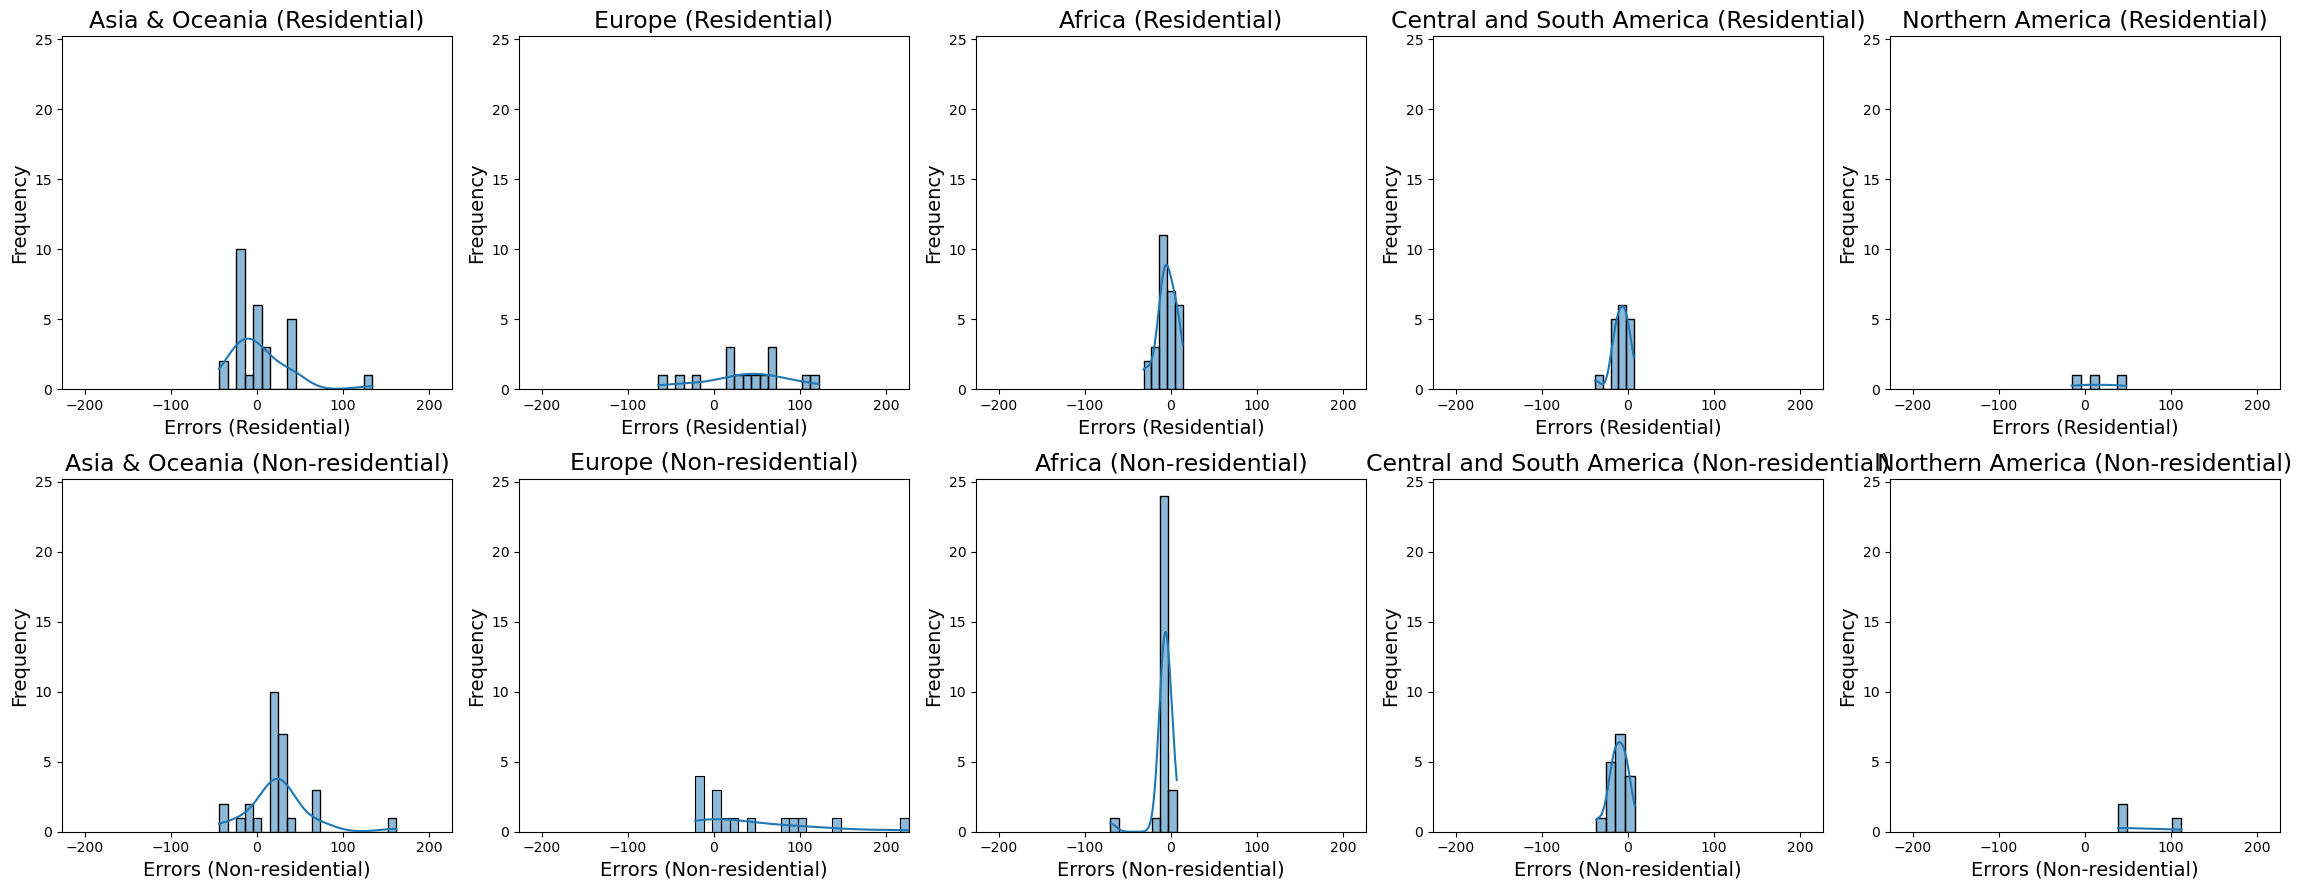

In [17]:
# Cross-domain
model_cat_cross = CatBoostRegressor(**cat_params)
results_cat_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_error_distribution.png')


### CatBoost - All Domain

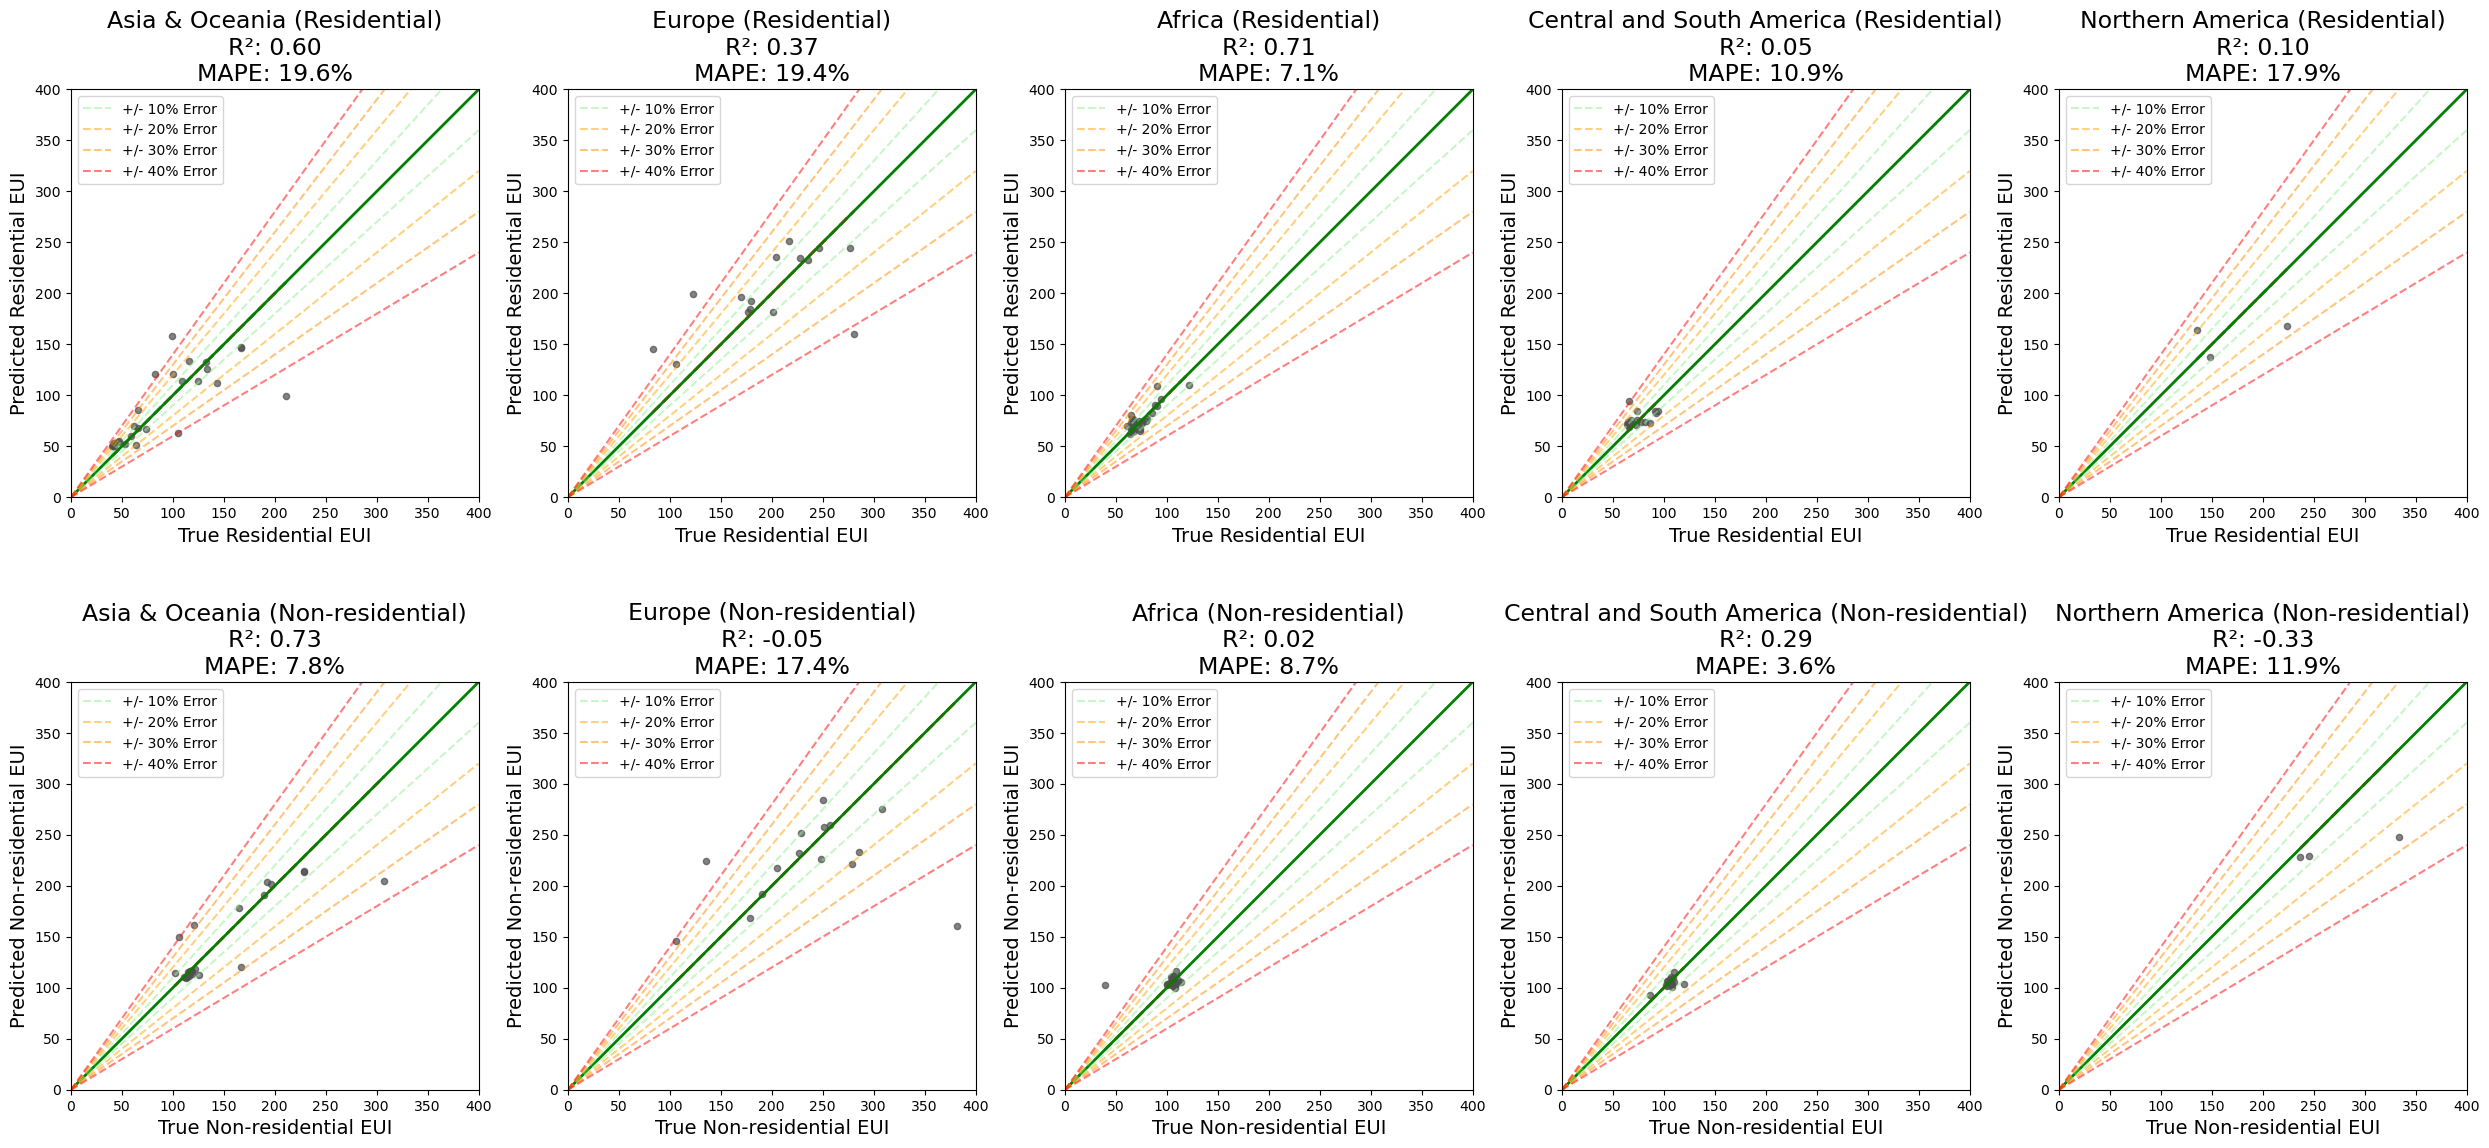

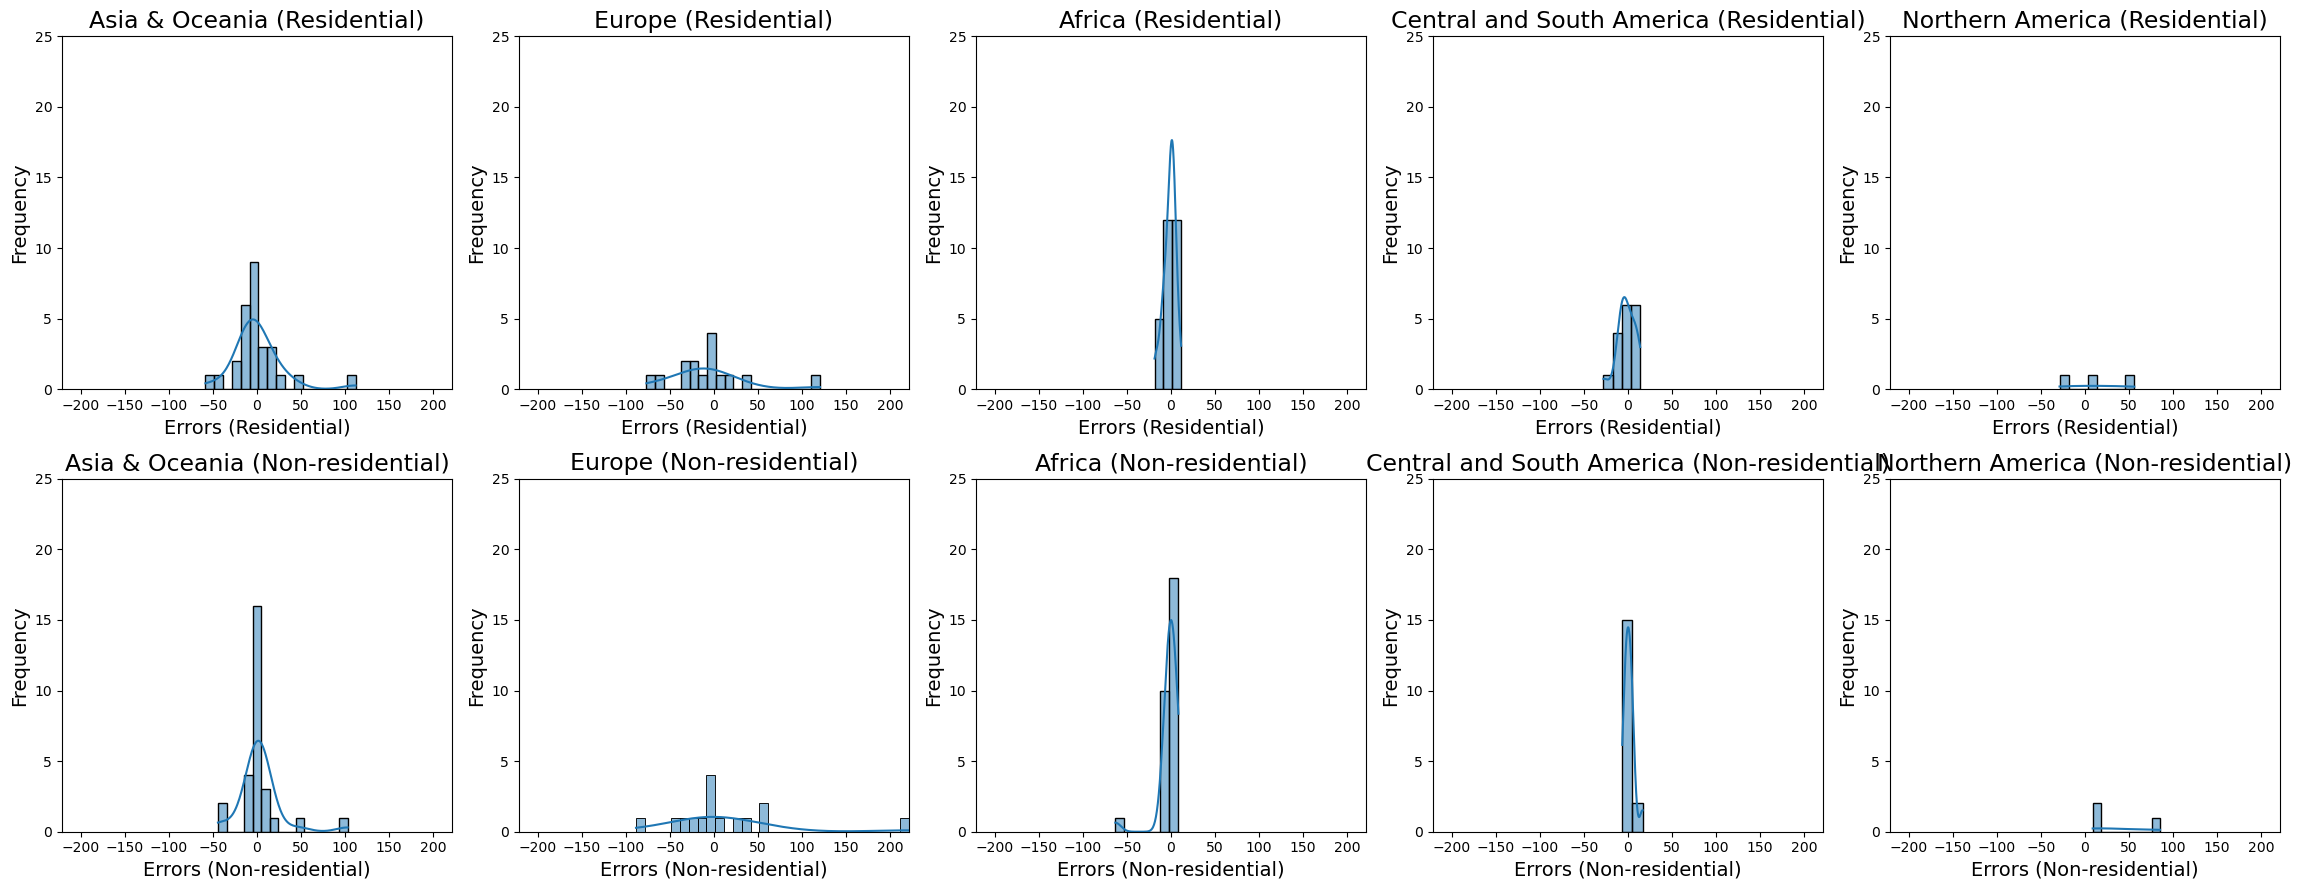

In [18]:
# All-domain
model_cat_all = CatBoostRegressor(**cat_params)
results_cat_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_error_distribution.png')

In [19]:
CatModel = lambda: CatBoostRegressor(**cat_params)

cat_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=CatModel,   
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in cat_params.items())
)

cat_detailed_results['Model'] = 'CatBoostRegressor'

cat_average_results = calculate_average_metrics(cat_detailed_results).reset_index()
cat_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,9.90,0.243,1439.684,30.132,20.246,9.42
1,Non-residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,17.60,-1.449,2878.876,45.821,34.133,17.86
2,Non-residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,9.88,0.133,1576.378,32.104,19.864,9.70
3,Residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,12.98,0.465,823.833,24.447,17.584,13.34
4,Residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,19.86,0.010,1266.305,30.552,24.841,19.40
5,Residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=100, depth=6, learning_rate=0.1, lo...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,14.98,0.367,861.951,25.420,18.853,14.64


In [20]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
cat_detailed_results.to_csv(f'../results/{timestamp}_cat_detailed_results.csv')
cat_average_results.to_csv(f'../results/{timestamp}_cat_average_results.csv')

# 